In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [2]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import InformerEstimator

/home/kashif/.env/pytorch/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
dataset = get_dataset("electricity")

In [13]:
estimator = InformerEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    
    # 
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],
    
    # attention hyper-params
    dim_feedforward=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    nhead=2,
    activation="relu",
    
    # training params
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', gpus=1),
)

In [14]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: F

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 6.61750 (best 6.61750), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/informer/lightning_logs/version_28/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 6.04776 (best 6.04776), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/informer/lightning_logs/version_28/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.84296 (best 5.84296), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/informer/lightning_logs/version_28/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.75401 (best 5.75401), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/informer/lightning_logs/version_28/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.63729 (best 5.63729), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/informer/lightning_logs/versi

In [22]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [23]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base is None or self._freq_base == start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:384: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  ..., i0 : i0 + length * start.freq.n : start.freq.n


In [17]:
tss = list(ts_it)

In [24]:
evaluator = Evaluator()

In [25]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 4083.04it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq i

In [26]:
agg_metrics

{'MSE': 1888823.0608803749,
 'abs_error': 9591290.831059933,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.9154653390940202,
 'MAPE': 0.1074732466564903,
 'sMAPE': 0.11906707750050609,
 'MSIS': 6.598265012752936,
 'QuantileLoss[0.1]': 3999428.6334216925,
 'Coverage[0.1]': 0.2343309597982495,
 'QuantileLoss[0.2]': 6374339.727818968,
 'Coverage[0.2]': 0.41968921524996294,
 'QuantileLoss[0.3]': 8000487.965688637,
 'Coverage[0.3]': 0.5595608960094942,
 'QuantileLoss[0.4]': 9068618.610809661,
 'Coverage[0.4]': 0.6701713395638629,
 'QuantileLoss[0.5]': 9591290.886452701,
 'Coverage[0.5]': 0.7554887998813232,
 'QuantileLoss[0.6]': 9447833.699609587,
 'Coverage[0.6]': 0.820260347129506,
 'QuantileLoss[0.7]': 8786171.793627966,
 'Coverage[0.7]': 0.877280818869604,
 'QuantileLoss[0.8]': 7443390.599792011,
 'Coverage[0.8]': 0.9237130989467439,
 'QuantileLoss[0.9]': 5049853.03397596,
 'Coverage[0.9]': 0.9628578845868567,
 '

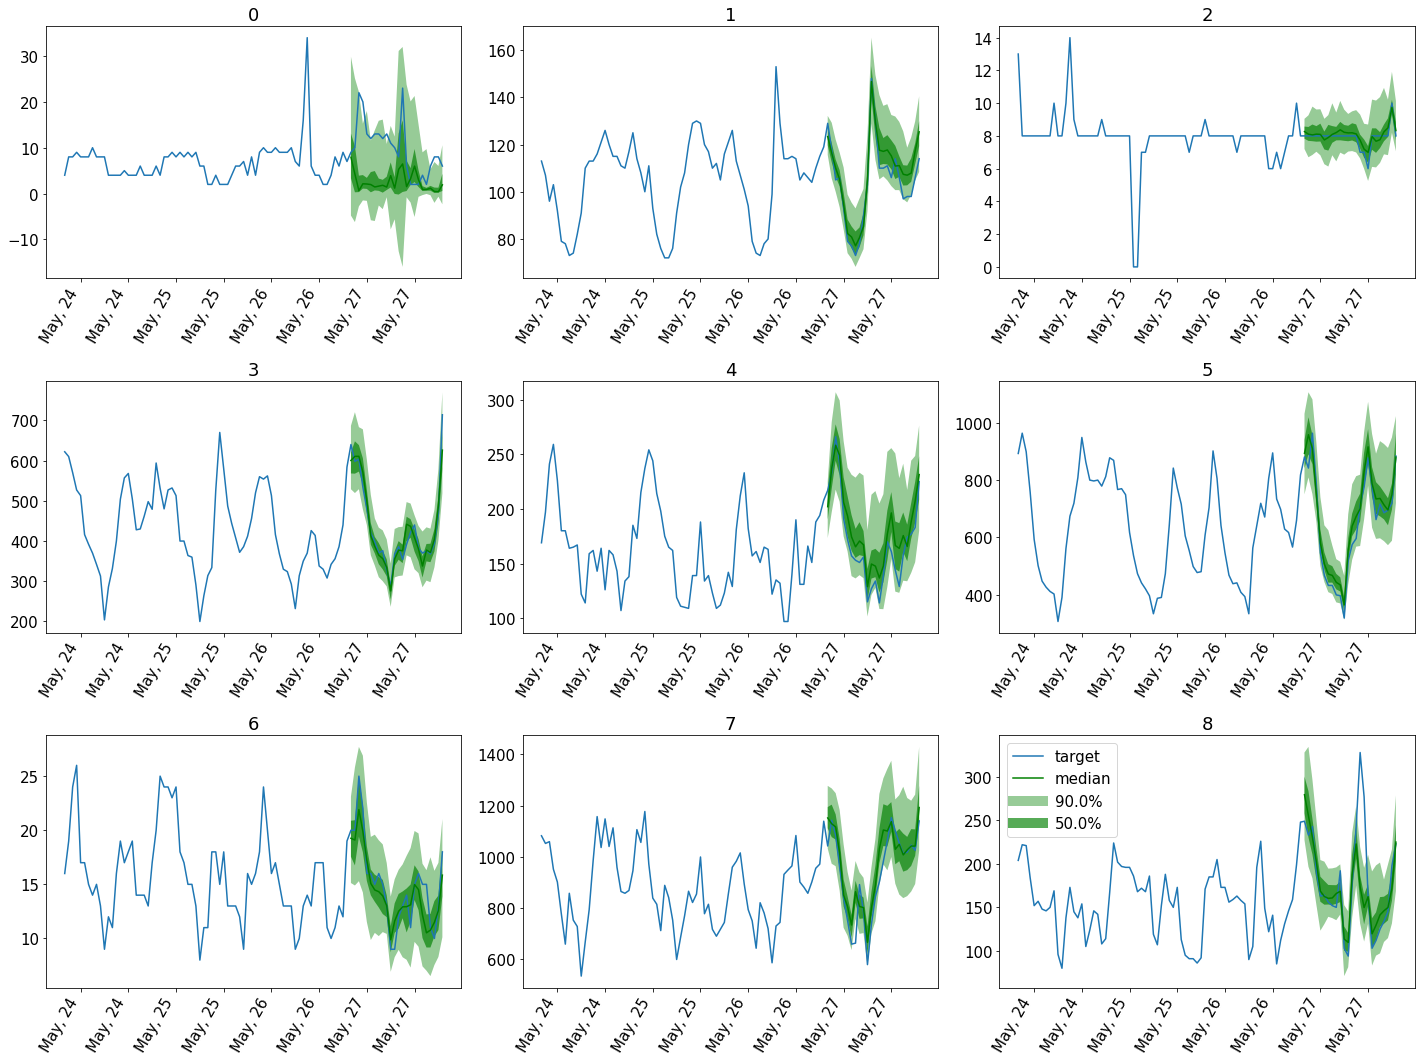

In [28]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()